In [1]:
import netCDF4
from osgeo import gdal
from osgeo import osr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import glob
import os
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
import xarray as xr


In [7]:
models = ["SMHI-RCA", "MPICSC-REMO1", "DMI-HIRHAM"]
variants = ["RCP85", "RCP45", "RCP26"]
variables = ["tas", "tasmax"]

models_dict = {model: {variant: glob.glob("../data/prognosedaten/*"+"_"+"*"+model+"*"+variant+"*"+".nc") for variant in variants} for model in models}

ds = xr.open_mfdataset(models_dict["MPICSC-REMO1"]["RCP85"])



In [8]:
ds

<xarray.Dataset>
Dimensions:  (lon: 220, lat: 101, time: 43464)
Coordinates:
  * lon      (lon) float64 5.938 5.958 5.979 6.0 ... 10.44 10.46 10.48 10.5
  * lat      (lat) float64 45.77 45.79 45.81 45.83 ... 47.79 47.81 47.83 47.85
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2099-12-31T12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(43464, 101, 220), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(43464, 101, 220), meta=np.ndarray>
Attributes:
    history:  Fri May 12 16:47:06 2017: ncatted -O -a units,tasmin,m,c,degree...

In [9]:
# what dimensions does the netCDF file have?
ds.dims

# the shape of lon 220 cells (each 2km) east-west, looks correct
# the shape of lat 101 cells (each 2km) north-south, looks correct
# the shape of time 43'434 days, ~118 days (1981-2099) looks correct

Frozen({'lon': 220, 'lat': 101, 'time': 43464})

In [10]:
# What variables does the dataset have?
ds.coords

Coordinates:
  * lon      (lon) float64 5.938 5.958 5.979 6.0 ... 10.44 10.46 10.48 10.5
  * lat      (lat) float64 45.77 45.79 45.81 45.83 ... 47.79 47.81 47.83 47.85
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2099-12-31T12:00:00

In [11]:
# sadly, not many attributes attached to the dataset
for key, val in ds.attrs.items():
    print(key, val, "\n")

history Fri May 12 16:47:06 2017: ncatted -O -a units,tasmin,m,c,degrees_C tasmin_only_atts.nc
Fri May 12 15:34:04 2017: ncatted -O -a method,tasmin,c,c,Bias-corrected and downscaled by QM tasmin_CLMCOM-CCLM4-MPIESM-EUR11-RCP85_QM_1981-2099_test_write_only_atts.nc 



In [12]:
# I can extract a specific range like so:
ds.sel(time = slice("2031-09-30", "2032-04-01"))

<xarray.Dataset>
Dimensions:  (lon: 220, lat: 101, time: 185)
Coordinates:
  * lon      (lon) float64 5.938 5.958 5.979 6.0 ... 10.44 10.46 10.48 10.5
  * lat      (lat) float64 45.77 45.79 45.81 45.83 ... 47.79 47.81 47.83 47.85
  * time     (time) datetime64[ns] 2031-09-30T12:00:00 ... 2032-04-01T12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(185, 101, 220), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(185, 101, 220), meta=np.ndarray>
Attributes:
    history:  Fri May 12 16:47:06 2017: ncatted -O -a units,tasmin,m,c,degree...

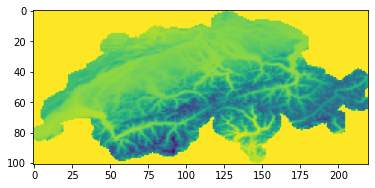

In [13]:
def hugglin(x):
    return (((x.tas-10)+(x.tasmax-10))/2)*1.045

ds_hugg = ds.sel(time = slice("2031-09-30", "2032-04-01")).groupby("time").map(hugglin).sum(dim="time")

plt.imshow(np.flip(ds_hugg, 0))


What I need to calculate is the following (pseudocode):

```
for years in 2031-2040:
    for days in 30.09.year-01.04.(year+1):
        ((tas-10)+(tas_max-10))/2*1.045
        
```


In [14]:
# Import the kanton of luzern ....
kantonsgrenze = gpd.read_file("../data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/", layer = "TLM_KANTONSGEBIET").query("NAME == 'Luzern'") # fiona.listlayers("data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/")

# buffer it with 2km, transform it to wsg84 and get the bounding box
kanton_bounds = kantonsgrenze.buffer(2000).to_crs(4326).bounds
kanton_bounds

,minx,miny,maxx,maxy
8,7.810031,46.757013,8.540349,47.30518


In [15]:
minx, maxx, miny, maxy = kanton_bounds["minx"].iloc[0], kanton_bounds["maxx"].iloc[0], kanton_bounds["miny"].iloc[0], kanton_bounds["maxy"].iloc[0]


Just as slicing over time, we can slice over lon / lat

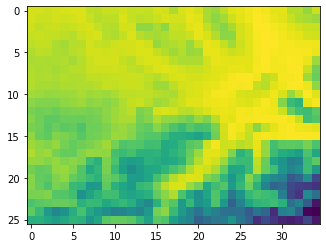

In [16]:
ds_hugg_lu = ds.sel(time = slice("2031-09-30", "2032-04-01"), lon = slice(minx, maxx), lat = slice(miny, maxy)).groupby("time").map(hugglin).sum(dim="time")


plt.imshow(np.flip(ds_hugg_lu, 0))

In [ ]:

for model_name in models_dict.keys():
    print("starting with model: ",model_name)
    for variant_name in models_dict[model_name]:
        print("... starting with variant: ",variant_name)
        nc_files = models_dict[model_name][variant_name]
        ds = xr.open_mfdataset(nc_files)
        
        all_years = []
        for year in range(2031, 2041):
            print("... .... starting with year: ", year)
            start = str(year)+"-04-01"
            end = str(year)+"-09-30"
            
            ds_hugg = ds.sel(time = slice(start, end), lon = slice(minx, maxx), lat = slice(miny, maxy)).groupby("time").map(hugglin).sum(dim="time")
            ds_hugg.rio.write_crs("EPSG:4326", inplace=True)
            ds_hugg_2056 = ds_hugg.rio.reproject("EPSG:2056")
            
            subdir = "../output/pronosis/"+model_name+"/"+variant_name+"/"
            os.makedirs(subdir, exist_ok=True)
            
            ds_hugg_2056.rio.to_raster(subdir+str(year)+".tif")
            

            
            all_years.append(ds_hugg_2056)
            
            del ds_hugg
        xr.concat(all_years, "time").mean(dim = "time").rio.to_raster(subdir+"Mean.tif")
        

In [32]:
model_name = "MPICSC-REMO1"
variant_name = "RCP26"
nc_files = models_dict[model_name][variant_name]

all_years = []
for year in range(2031, 2041):
    print("... .... starting with year: ", year)
    start = str(year)+"-04-01"
    end = str(year)+"-09-30"

    ds_hugg = ds.sel(time = slice(start, end), lon = slice(minx, maxx), lat = slice(miny, maxy)).groupby("time").map(hugglin).sum(dim="time")
    ds_hugg.rio.write_crs("EPSG:4326", inplace=True)
    ds_hugg_2056 = ds_hugg.rio.reproject("EPSG:2056")


    all_years.append(ds_hugg_2056)

    del ds_hugg

... .... starting with year:  2031


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2032


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2033


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2034


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2035


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2036


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2037


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2038


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2039


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


... .... starting with year:  2040


/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


In [76]:
all_years_df = xr.concat(all_years, "time").mean(dim = "time",skipna = True)

/home/nils/miniconda3/envs/geopython/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [204]:
#np.isfinite(all_years_df)
all_years_df.where(np.isfinite(all_years_df)).mean().values

#[x.where(np.isfinite(x)).mean().values for x in all_years]

year1 = all_years[1]


[x.where(np.less_equal(x, 3.40282346e+38)).mean() for x in all_years]
year1.where(np.less_equal(year1, 3.40282346e+38)).mean()
# continue here: I must drop the spatial ref and just take the values, then how the mean value changes over time
# also make sure that calculating the mean over all years returns a valid raster (and all inf values are gone)


<bound method DataArray.drop_vars of <xarray.DataArray ()>
array(919.55994, dtype=float32)
Coordinates:
    spatial_ref  int64 0>

In [45]:
all_years[4]

<xarray.DataArray (y: 32, x: 30)>
array([[ 1.50991064e+03,  1.52164771e+03,  1.48262915e+03,
         1.51905518e+03,  1.51848193e+03,  1.52909912e+03,
         1.38779272e+03,  1.35158276e+03,  1.41191699e+03,
         1.49348242e+03,  1.39819458e+03,  1.42217773e+03,
         1.39408008e+03,  1.45993152e+03,  1.28981079e+03,
         1.50309631e+03,  1.56617554e+03,  1.48627710e+03,
         1.24700171e+03,  1.39842432e+03,  1.54817725e+03,
         1.58277222e+03,  1.62225781e+03,  1.65516992e+03,
         1.56116064e+03,  1.55800269e+03,  1.37842139e+03,
         1.36074609e+03,  1.23016052e+03,  3.40282347e+38],
       [ 1.50991064e+03,  1.47479224e+03,  1.47097949e+03,
         1.48136353e+03,  1.48754260e+03,  1.53024707e+03,
         1.43990063e+03,  1.34129932e+03,  1.35455225e+03,
         1.51026855e+03,  1.39195117e+03,  1.34223608e+03,
         1.36473730e+03,  1.48335791e+03,  1.46087671e+03,
         1.47722144e+03,  1.58269153e+03,  1.54827734e+03,
         1.20154944e+03,  1.28491809e+03,  1.46155127e+03,
         1.56935791e+03,  1.60262500e+03,  1.66496533e+03,
         1.59904578e+03,  1.54832983e+03,  1.44091748e+03,
         1.34194580e+03,  1.30723108e+03,  3.40282347e+38],
...
       [ 9.34660645e+02,  6.45881409e+02,  1.91084732e+02,
        -2.55910797e+01,  5.01877441e+02,  8.10122681e+02,
         4.46954773e+02,  2.26079712e+02,  9.93780975e+01,
        -2.16893005e+00,  1.20685730e+02,  3.39779205e+01,
         3.11579407e+02,  1.27838660e+03,  1.40143140e+03,
         3.79570007e+02,  1.06952896e+02, -1.34926285e+02,
         2.46756790e+02,  4.63813019e+01, -1.82715164e+02,
        -1.45724457e+02, -3.77701050e+02, -1.30300705e+02,
        -2.75025330e+02, -7.86266296e+02,  4.37307281e+01,
        -3.56770935e+02, -1.10216162e+03, -1.15068774e+03],
       [ 4.93889923e+02,  5.18666016e+02,  4.19686462e+02,
         2.86434967e+02,  6.11584839e+02,  5.87235107e+02,
         2.18011261e+02,  4.36007965e+02,  1.02284961e+03,
         1.11754797e+03,  1.06447766e+03,  7.56875732e+02,
         4.38894531e+02,  1.14501587e+03,  1.07947949e+03,
         2.02920120e+02,  1.18008545e+02, -2.84284576e+02,
        -1.52387146e+02, -2.60078125e+01,  3.03196320e+02,
        -6.26676941e+01, -2.98273529e+02, -7.43108154e+02,
        -5.22793823e+02, -6.73980225e+02, -8.93721008e+02,
        -8.26793884e+02, -5.61352478e+02, -9.62866455e+02]], dtype=float32)
Coordinates:
  * x            (x) float64 2.628e+06 2.63e+06 ... 2.681e+06 2.683e+06
  * y            (y) float64 1.239e+06 1.237e+06 ... 1.182e+06 1.18e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38